
## captions are strictly mandatory: no captions no points. The discussion of what you do is the ultimate deliverable of each task

Captions need to describe: what is plotted and what is interesting about it


PLEASE REMEMBER: download your data in a reproducible way, seed your random functions if you need to use any, label your axes clearly, captions for each figure that explains what is shown, and what is noticeable about it, comment your code.






## respect coding standards
*The [following PEP8 rules](https://docs.google.com/document/d/1-XnKK4xRBA5FXOBa4p0Z4in7qfVyk4CutjSMEX-jpTQ/edit?usp=sharing) are now required*

Points will be taken off if they are violated

## problem statement

** An interesting and popular urban science question is "can we measure and predict energy use based on observables that are easily acquired". For example the urban observatory at CUSP can monitor lights: they are a relatively easy observable. All you need is a camera, and a pipeline to process your data. But how does the light coming from a window relate to the total energy consumption? We generally postulate that light is a proxy for occupancy, and that occupancy is a good predictor of energy consumption.**

** So let's test if the last link holds. If we have data on the _energy consumed by a building_ how well does that relate to the _number of units_ in the building?**

** Data on energy consumption can be found here for the city of NY https://data.cityofnewyork.us/Environment/Energy-and-Water-Data-Disclosure-for-Local-Law-84-/rgfe-8y2z  **

** Either obtain the data through the API or download the csv file, and move it to $PUIDATA**

** However this datasets does not have the number of units. We can find that in the [Pluto dataset](https://www1.nyc.gov/site/planning/data-maps/open-data/dwn-pluto-mappluto.page).**

** Reading in the Pluto data for manhattan, which will give me the number of units ber building   Manhattan/MNMapPLUTO.shp ** Note that you should keep all the files in the original MNMapPluto zipped folder (not just the .shp file) for geopandas to read the data in correctly.

# data acquisition

## download, move data to $PUIDATA, and read data in 
make sure you limit the PLUTO dataset to Manhattan, The entire NYC PLUTO dataset is huge!

...download...

In [600]:
import pandas as pd
import geopandas as gp
import statsmodels.formula.api as smf
import statsmodels.stats.sandwich_covariance as sw
import os
import pylab as pl
import urllib
import zipfile
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib import cm
from matplotlib import gridspec
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['norm']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [601]:
url = 'https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/mn_mappluto_18v1.zip'
urllib.request.urlretrieve(url, "mn_mappluto_18v1.zip")

('mn_mappluto_18v1.zip', <http.client.HTTPMessage at 0x7f7b92734588>)

In [602]:
os.system("mv " + "mn_mappluto_18v1.zip" + os.getenv("PUIDATA"))

256

In [603]:
zip_ref = zipfile.ZipFile(os.getenv("PUIDATA") + "/mn_mappluto_18v1.zip", 'r')
zip_ref.extractall(os.getenv("PUIDATA"))
zip_ref.close()

In [604]:
# load the buildinmg size as a geoDF and the local law 84 as a dtaframe
nrg = pd.read_csv(os.getenv("PUIDATA") + 
                  "/Energy_and_Water_Data_Disclosure_for_Local_Law_84_2014__Data_for_Calendar_Year_2013_.csv")

bsize = gp.GeoDataFrame.from_file(os.getenv("PUIDATA") + "/MNMapPLUTO.shp")

## exploring the data a bit

As we discussed, coming up with a sensible model generally requires domain expertise. However, if the data you are investigating shows "obvious patterns", for example if two of the variable look like a line when plotted one against the other, then those patterns (correlations) may help you finding reasonable models for the data.

Explore your data, starting with a scatter matrix. 
A scatter matrix is a plot of all variables in your data against all other variables: 
each pair of variables is a subplot in the plot matrix. The diagonal line then would be a plot of a variable against itself, which is useless, so it is usually substituted by a histogram of that variable (or sometimes a KDE, which is basically a smooth histogram).

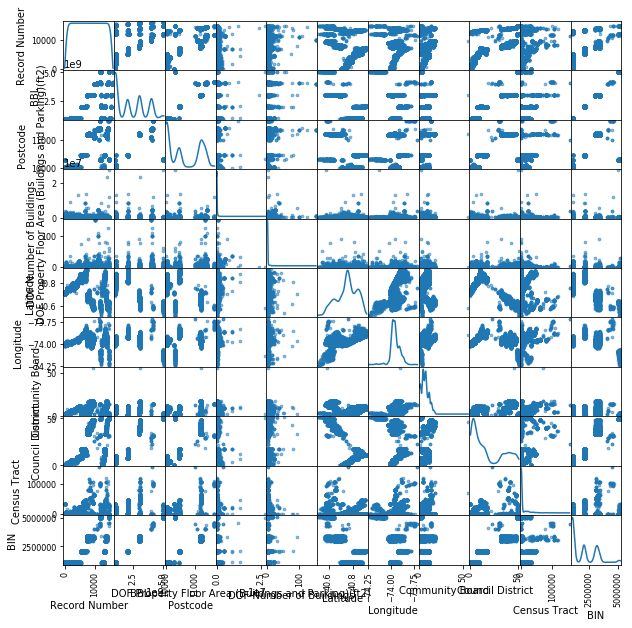

In [605]:
sfig = pd.scatter_matrix(nrg, s=30, figsize=(10, 10), diagonal='kde')

Figure 1: Scatter Matrix between various variables in the Data on Energy Consumption file. They show the correlations between variables, And does not show those that cannot be plotted, because the variables are strings, not floats. Variables compared to themselves are line graphs with a coherent pattern, but some variables, such as BIN to Record Number, for example, seems to be linearly related.

This kind of plot shows correlations between variables, but it will also show me what can and cannot be plotted trivially in my dataset. Here only a few columns can be plotted: those that contain only numbers (and possibly NaN's), but most columns contain rows that cannot be converted to float (e.g. entries like 'See Primary BBL' in several rows for the energy dataframe 'Site EUI(kBtu/ft2) ' column) , so Pandas refuses to plot them, cause it does not know what to do with those entries. The columns I am interested in are in fact u'Site EUI(kBtu/ft2)' which is a measure of the energy consumed PER SQ FOOT by a building, and then the building area: for eg. u'Reported Property Floor Area (Building(s)) (ft²)'. Neither gets plotted: I need to remove all values that cannot convert to float in order to use the columns and convert them to float arrays and do math with them.

You can use pd.to_numeric() which is a function that transforms values to float (when possible). The default behavior of this function is to throw an error if it encounters a value that it cannot convert. That behavior can be modified with the "error" keyword, by setting it to "coerce". Please look at the function documentation to understand the syntax.

## data cleaning and aggregation 
### checking the content of the datasets


clean up columns I am not using: for my solution, I will keep  BBL, 'Site EUI(kBtu/ft2)', 'Reported Property Floor Area (Building(s)) (ft²)' from the energy dataframe, and BBL , UnitsTotal, UnitsRes, 'YearBuilt', and 'geometry' from the PLUTO geodaraframe

### remove what you do not need

In [606]:
nrg.columns

Index(['Record Number', 'BBL', 'Co-reported BBL Status', 'BBLs Co-reported', 'Reported NYC Building Identificaiton Numbers (BINs)', 'Street Number', 'Street Name', 'Borough', 'Postcode', 'DOF Benchmarking Submission Status', 'Site EUI(kBtu/ft2)', 'Weather Normalized Site EUI(kBtu/ft2)', 'Source EUI(kBtu/ft2)', 'Weather Normalized Source EUI(kBtu/ft2)', 'Municipally Supplied Potable Water - Indoor Intensity (gal/ft²)', 'Automatic Water Benchmarking Eligible', 'Reported Water Method', 'ENERGY STAR Score', 'Total GHG Emissions(MtCO2e)', 'Direct GHG Emissions(MtCO2e)', 'Indirect GHG Emissions(MtCO2e)', 'Reported Property Floor Area (Building(s)) (ft²)', 'DOF Property Floor Area (Buildngs and Parking)(ft2)', 'Primary Property Type - Self Selected', 'DOF Number of Buildings', 'Latitude', 'Longitude', 'Community Board', 'Council District', 'Census Tract', 'BIN', 'NTA'], dtype='object')

In [607]:
bsize.columns.sort_values()

Index(['APPBBL', 'APPDate', 'Address', 'AreaSource', 'AssessLand', 'AssessTot', 'BBL', 'BldgArea', 'BldgClass', 'BldgDepth', 'BldgFront', 'Block', 'BoroCode', 'Borough', 'BsmtCode', 'BuiltFAR', 'CB2010', 'CD', 'CT2010', 'ComArea', 'CommFAR', 'CondoNo', 'Council', 'EDesigNum', 'Easements', 'ExemptLand', 'ExemptTot', 'Ext', 'FIRM07_FLA', 'FacilFAR', 'FactryArea', 'FireComp', 'GarageArea', 'HealthArea', 'HealthCent', 'HistDist', 'IrrLotCode', 'LandUse', 'Landmark', 'Lot', 'LotArea', 'LotDepth', 'LotFront', 'LotType', 'LtdHeight', 'MAPPLUTO_F', 'NumBldgs', 'NumFloors', 'OfficeArea', 'OtherArea', 'Overlay1', 'Overlay2', 'OwnerName', 'OwnerType', 'PFIRM15_FL', 'PLUTOMapID', 'PolicePrct', 'ProxCode', 'ResArea', 'ResidFAR', 'RetailArea', 'SHAPE_area', 'SHAPE_len', 'SPDist1', 'SPDist2', 'SPDist3', 'Sanborn', 'SanitBoro', 'SanitDistr', 'SanitSub', 'SchoolDist', 'SplitZone', 'StrgeArea', 'TaxMap', 'Tract2010', 'UnitsRes', 'UnitsTotal', 'Version', 'XCoord', 'YCoord', 'YearAlter1', 'YearAlter2',
  

In [608]:
#leave
nrg.drop(['Record Number', 'Co-reported BBL Status', 'BBLs Co-reported',
       'Reported NYC Building Identificaiton Numbers (BINs)', 'Street Number',
       'Street Name', 'Borough', 'Postcode',
       'DOF Benchmarking Submission Status',
       'Weather Normalized Site EUI(kBtu/ft2)', 'Source EUI(kBtu/ft2)',
       'Weather Normalized Source EUI(kBtu/ft2)',
       'Municipally Supplied Potable Water - Indoor Intensity (gal/ft²)',
       'Automatic Water Benchmarking Eligible', 'Reported Water Method',
       'ENERGY STAR Score', 'Total GHG Emissions(MtCO2e)',
       'Direct GHG Emissions(MtCO2e)', 'Indirect GHG Emissions(MtCO2e)',
       'DOF Property Floor Area (Buildngs and Parking)(ft2)',
       'Primary Property Type - Self Selected', 'DOF Number of Buildings',
       'Latitude', 'Longitude', 'Community Board', 'Council District',
       'Census Tract', 'BIN', 'NTA'], axis=1, inplace=True)
nrg.head()

,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²)
0,1.000410e+09,NaN,918919
1,4.021460e+09,NaN,NaN
2,2.027620e+09,NaN,64200
3,1.006700e+09,NaN,NaN
4,2.048300e+09,NaN,50000


In [609]:
#leave
bsize.drop(['APPBBL', 'APPDate', 'Address', 'AreaSource', 'AssessLand', 'AssessTot',
       'BldgArea', 'BldgClass', 'BldgDepth', 'BldgFront', 'Block',
       'BoroCode', 'Borough', 'BsmtCode', 'BuiltFAR', 'CB2010', 'CD', 'CT2010',
       'ComArea', 'CommFAR', 'CondoNo', 'Council', 'EDesigNum', 'Easements',
       'ExemptLand', 'ExemptTot', 'Ext', 'FIRM07_FLA', 'FacilFAR',
       'FactryArea', 'FireComp', 'GarageArea', 'HealthArea', 'HealthCent',
       'HistDist', 'IrrLotCode', 'LandUse', 'Landmark', 'Lot', 'LotArea',
       'LotDepth', 'LotFront', 'LotType', 'LtdHeight', 'MAPPLUTO_F',
       'NumBldgs', 'NumFloors', 'OfficeArea', 'OtherArea', 'Overlay1',
       'Overlay2', 'OwnerName', 'OwnerType', 'PFIRM15_FL', 'PLUTOMapID',
       'PolicePrct', 'ProxCode', 'ResArea', 'ResidFAR', 'RetailArea',
       'SHAPE_area', 'SHAPE_len', 'SPDist1', 'SPDist2', 'SPDist3', 'Sanborn',
       'SanitBoro', 'SanitDistr', 'SanitSub', 'SchoolDist', 'SplitZone',
       'StrgeArea', 'TaxMap', 'Tract2010', 'Version',
       'XCoord', 'YCoord', 'YearAlter1', 'YearAlter2', 'ZMCode',
       'ZipCode', 'ZoneDist1', 'ZoneDist2', 'ZoneDist3', 'ZoneDist4',
       'ZoneMap'], axis=1, inplace=True)
bsize.head()

,UnitsRes,UnitsTotal,YearBuilt,BBL,geometry
0,16,18,1920,1.015450e+09,"POLYGON ((997277.2344360352 221816.0936279297,..."
1,50,50,1914,1.007238e+09,"POLYGON ((984164.5626220703 211846.0704345703,..."
2,10,10,1910,1.016800e+09,"POLYGON ((1000742.195800781 227910.6640014648,..."
3,29,32,1928,1.013850e+09,"POLYGON ((994007.6885986328 219880.4284057617,..."
4,26,26,1900,1.011970e+09,"POLYGON ((992273.6849975586 224863.4904174805,..."


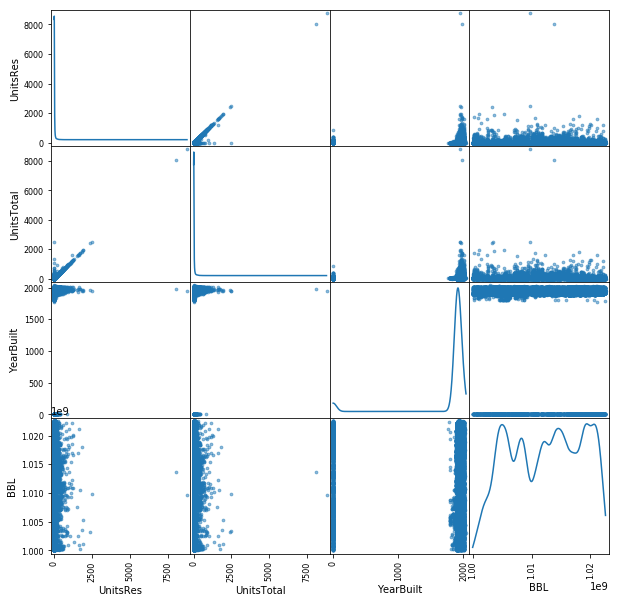

In [610]:
#leave (dont try this scatter matrix before cleaning the data, it will take a while)
sfig = pd.scatter_matrix(bsize, s=30, figsize=(10, 10), diagonal='kde')

Figure 2: Cleaned up scatter matrix between necessary columns in the pluto dataset. Units total with Units Res seems to be directly linearly related to each other. 

## converting  the relevant columns to numeric values and throwing away spurious entries

use pd.to_numeric() to convert strings to numeric values, remember the keyword "errors" which will be useful


In [611]:
##check that your conversion worked: e.g.

nrg['Site EUI(kBtu/ft2)'] = pd.to_numeric(nrg['Site EUI(kBtu/ft2)'], errors='coerce')

nrg['Reported Property Floor Area (Building(s)) (ft²)'] = pd.to_numeric(nrg['Reported Property Floor Area (Building(s)) (ft²)'],
                                                                        errors='coerce')

bsize.BBL = pd.to_numeric(bsize.BBL, errors='coerce')

nrg['Site EUI(kBtu/ft2)'].astype(float)[:10], bsize.BBL.astype(float)[:10]

#[...] do this for all columns you care about in both datasets. 
#Nan's are ok, but you must not get an error when you try the conversion
#the Pluto data is much better at not using spurious entries for numerical value columns. 
#but check you can use the columns you want

#this should not return an error
#notice I can use the attribute notation to refer to columns in bsize, 
#cause the column names do not have spaces!



(0   NaN
 1   NaN
 2   NaN
 3   NaN
 4   NaN
 5   NaN
 6   NaN
 7   NaN
 8   NaN
 9   NaN
 Name: Site EUI(kBtu/ft2), dtype: float64, 0    1.015450e+09
 1    1.007238e+09
 2    1.016800e+09
 3    1.013850e+09
 4    1.011970e+09
 5    1.002360e+09
 6    1.008370e+09
 7    1.001960e+09
 8    1.022240e+09
 9    1.011270e+09
 Name: BBL, dtype: float64)

In [612]:
##check that your conversion worked: e.g.
print ("number of missing energy observations:", np.isnan(nrg['Site EUI(kBtu/ft2)'].astype(float)).sum())

number of missing energy observations: 4623


In [613]:
##check that your conversion worked: e.g.
print ("fraction of missing energy observations: %.2f"%(np.isnan(nrg['Site EUI(kBtu/ft2)'].astype(float)).sum() /
      len(nrg['Site EUI(kBtu/ft2)'])))

fraction of missing energy observations: 0.29


 ## merge the 2 datasets
 I can merge the dataframes on NYC Borough, Block, and Lot: BBL

In [614]:
nrg.head()

,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²)
0,1.000410e+09,NaN,918919.0
1,4.021460e+09,NaN,NaN
2,2.027620e+09,NaN,64200.0
3,1.006700e+09,NaN,NaN
4,2.048300e+09,NaN,50000.0


In [615]:
bblnrgdataGPD = bsize.merge(nrg, left_on='BBL', right_on='BBL', how='inner')

In [616]:
bblnrgdataGPD.head()

,UnitsRes,UnitsTotal,YearBuilt,BBL,geometry,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²)
0,50,50,1914,1.007238e+09,"POLYGON ((984164.5626220703 211846.0704345703,...",68.7,95844.0
1,29,32,1928,1.013850e+09,"POLYGON ((994007.6885986328 219880.4284057617,...",87.4,206989.0
2,72,72,1923,1.021740e+09,"POLYGON ((1004080.155029297 252930.9956054688,...",140.4,52920.0
3,107,108,1931,1.008830e+09,"POLYGON ((989337.639831543 209686.7838134766, ...",96.5,98359.0
4,134,138,1910,1.008570e+09,"POLYGON ((988035.3540039062 210290.9854125977,...",36.4,154000.0


In [617]:
bblnrgdataGPD.columns

Index(['UnitsRes', 'UnitsTotal', 'YearBuilt', 'BBL', 'geometry', 'Site EUI(kBtu/ft2)', 'Reported Property Floor Area (Building(s)) (ft²)'], dtype='object')

In [618]:
bblnrgdata = bblnrgdataGPD[['UnitsRes', 'UnitsTotal', 'YearBuilt', 'BBL',
       'Site EUI(kBtu/ft2)',
       'Reported Property Floor Area (Building(s)) (ft²)']]

In [619]:
#bblnrgdata = gp.GeoDataFrame(bblnrgdata)

In [620]:
bblnrgdata.head()

,UnitsRes,UnitsTotal,YearBuilt,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²)
0,50,50,1914,1.007238e+09,68.7,95844.0
1,29,32,1928,1.013850e+09,87.4,206989.0
2,72,72,1923,1.021740e+09,140.4,52920.0
3,107,108,1931,1.008830e+09,96.5,98359.0
4,134,138,1910,1.008570e+09,36.4,154000.0


# Plot the data as a choropleth for the 2 quantities of interest: number of units and energy consumed energy

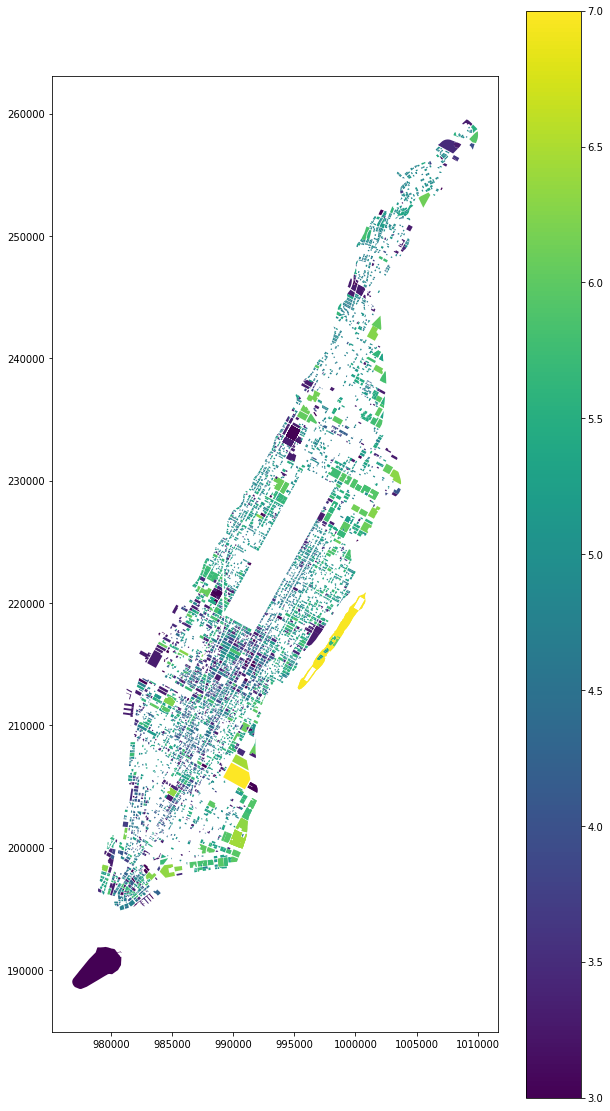

In [621]:
bblnrgdataGPD['logarea'] = bblnrgdataGPD.UnitsTotal.apply(lambda x: log(x+1))

ax = bblnrgdataGPD.plot(column ='logarea',figsize=(10,20), legend = False)

norm = Normalize(vmin=3, vmax=7)

n_cmap = cm.ScalarMappable(norm=norm, cmap="viridis")

n_cmap.set_array([])

ax.get_figure().colorbar(n_cmap, ax=ax, orientation='vertical')

Figure 3: Chloropleth map of Manhattan showing the number of units total in log. More yellow means higher density of units, more blue means lower density. Roosevelt Island makes sense for being highly concentrated with density of units. However, there are many empty areas, such as central part and lower and upper manhattan. These might be areas with large parks, roads, construction space, or uncounted buildings in the pluto data. The dictionary states that Units total include residential and non-residential units, such as offices and retail space, but non-residential units may not be counted if the same building also contains residential units, and a non-residential building may be counted as two units if the building has both office and retail units, but not for office and residential, so take that into consideration for the density in units total.

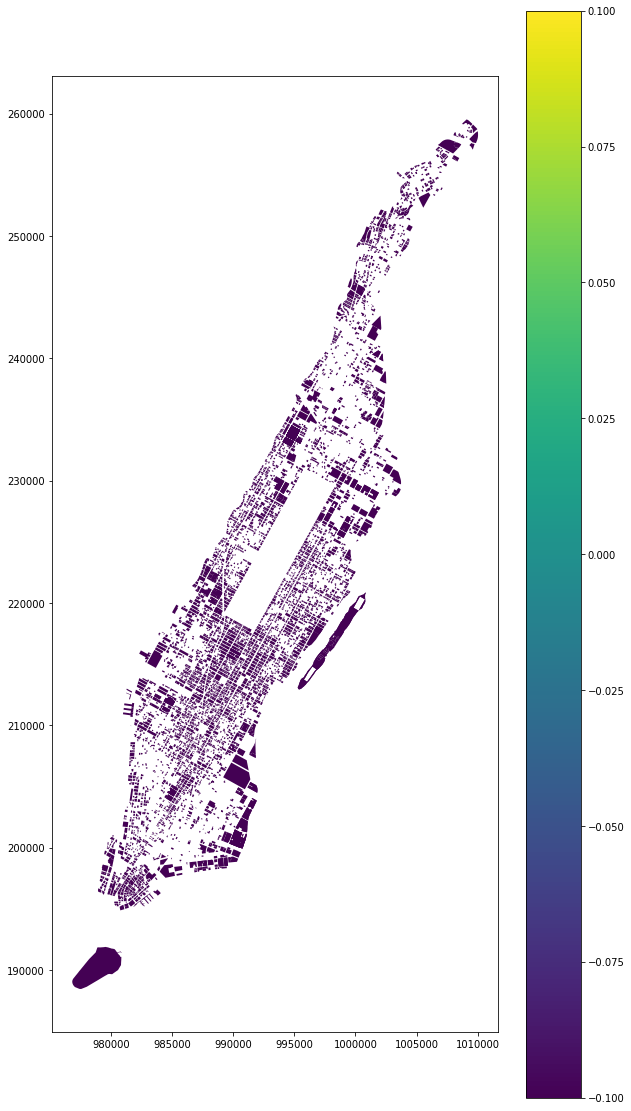

In [622]:
bblnrgdataGPD['lognrg'] = bblnrgdataGPD['Site EUI(kBtu/ft2)'].apply(lambda x: log(x))

ax = bblnrgdataGPD.plot(column ='lognrg',figsize=(10,20), legend = True)

Figure 4: Chloropleth map of Manhattan showing the number of energy consumed in log. There are many empty areas, such as central part and lower and upper manhattan. These might be areas with large parks, roads, construction space, or uncounted buildings in the pluto data. The majority of energy useage is seemingly low or uniform across Manhattan.

# feature engineering
the question was not if larger buildings consume more energy, its if occupancy increases consumption, so we want to model *total energy* with *total units*.
Create a total energy column from the columns you have.
Plot a column vs the other. You will be unable to see most of the points (as in the plot below). Make another plot "zooming in" to remove some outliers from the view and see if this reveals some patterns.

In [623]:
## multiplying area by energy/area to get total energy per building
bblnrgdata['nrg'] = bblnrgdata['Reported Property Floor Area (Building(s)) (ft²)'].astype(float) *\
                bblnrgdata['Site EUI(kBtu/ft2)'].astype(float)
bblnrgdata.head()

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,UnitsRes,UnitsTotal,YearBuilt,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),nrg
0,50,50,1914,1.007238e+09,68.7,95844.0,6584482.8
1,29,32,1928,1.013850e+09,87.4,206989.0,18090838.6
2,72,72,1923,1.021740e+09,140.4,52920.0,7429968.0
3,107,108,1931,1.008830e+09,96.5,98359.0,9491643.5
4,134,138,1910,1.008570e+09,36.4,154000.0,5605600.0


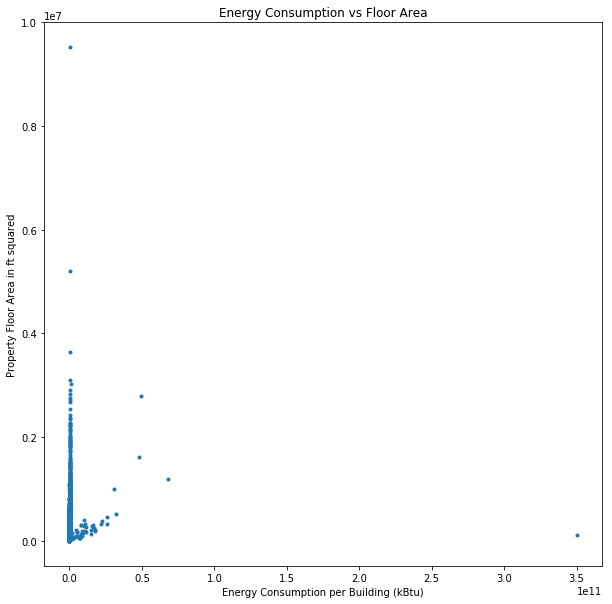

In [624]:
pl.figure(figsize=(10,10))
pl.plot(bblnrgdata.nrg, bblnrgdata['Reported Property Floor Area (Building(s)) (ft²)'], '.')
pl.title('Energy Consumption vs Floor Area')
pl.xlabel('Energy Consumption per Building (kBtu)')
pl.ylabel('Property Floor Area in ft squared')
pl.show()

Figure 5: Energy Consumption per building in kBtu vs floor area in ft squared, with outliers

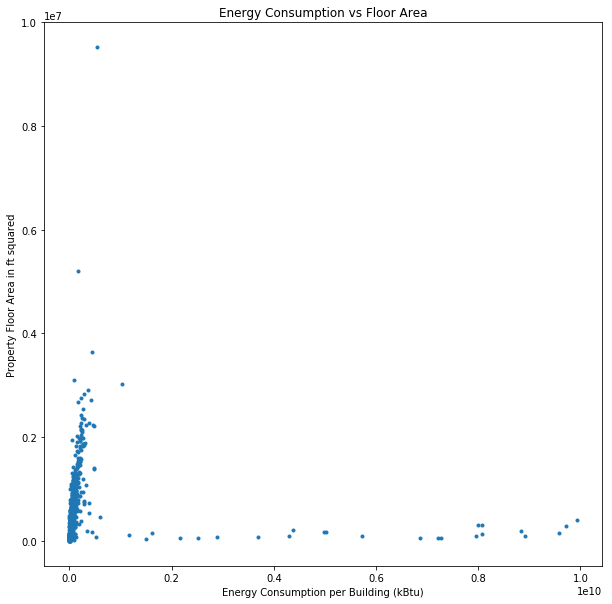

In [625]:
bblnrgdata = bblnrgdata[bblnrgdata.nrg <1e10]

pl.figure(figsize=(10,10))
pl.plot(bblnrgdata.nrg, bblnrgdata['Reported Property Floor Area (Building(s)) (ft²)'], '.')
pl.title('Energy Consumption vs Floor Area')
pl.xlabel('Energy Consumption per Building (kBtu)')
pl.ylabel('Property Floor Area in ft squared')
pl.show()

Figure 6: Energy Consumption per building in kBtu vs floor area in ft squared, with outliers of Energy Consumption removed.

# The magic of log scales!
**Please read the following vcarefully! this is the only opportunity I have to discuss this with you this year. **

Very often in science we will visualize data in log scale and model log data instead of the natural dataset (generally in log10).

In in log10 every order of magnitude is separate by a unit: log10(10) = 1, log10(100) = 2, log10(100000)=5 (basically log10 gives you the number of 0's in its argument, or the *order of magnitude*)





Text(0,0.5,'$log_{10}$(x)')

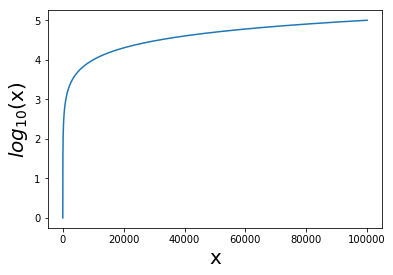

In [626]:
pl.plot(np.arange(100000), np.log10(np.arange(100000)), '-')
pl.xlabel("x", fontsize=20)
pl.ylabel(r"$log_{10}$(x)", fontsize=20)

The logarithm is a monotonic function : wherever its argument grows the function grows, wherever its argument decrease its log decrease. It's a function that grows fast when the argument is small and slowly when the argument is large, so it compresses the scale. 

Another property of the logarithm is that if the relationship between data is a power law (y = x^a) then the relationship between the log of the variables is linear! And we know that modeling things with linear models is easy!

	log_10(x^y) = y ∙ log_10(x)
    
And since power laws are very common in nature we often model with power laws, or with inear relationships in log space.

# Plot both NRG vs Units total and Units total vs NRG, both in log space

Surely there is a right way to think about which one is the independent and the dependent variable in this problem: do we think energy consumption causes occupancy or occupancy causes consumption?

You are going to have to limit the axis values or you will not see anything: 

    energy between (1000,1e10)

    units between (1,1000)

You can cut the axis to visualize the data like this, **but you will need to cut the data to remove datapoint outside of this range when you model to get a good model.**

to visualize the data in log scale you can use the dataframe plotting method with the argument 

    loglog=True


In [627]:
bblnrgdataCut = bblnrgdata.copy(deep=True)

Text(0,0.5,'nrg')

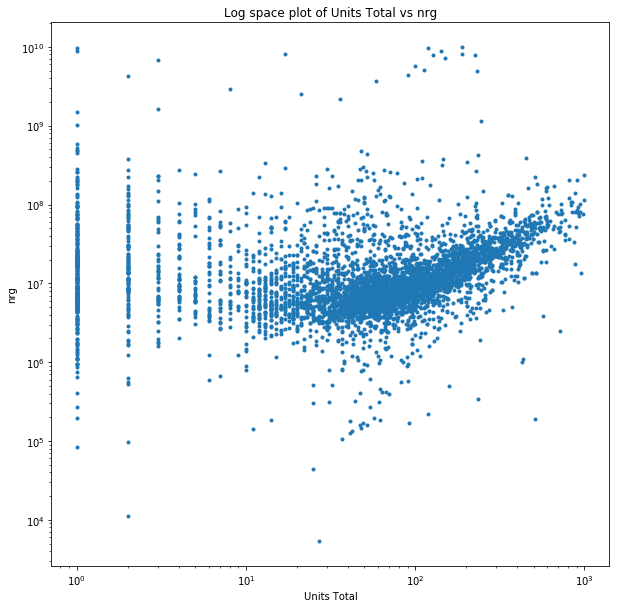

In [628]:
bblnrgdataCut = bblnrgdataCut[bblnrgdataCut.nrg <= 1e10]
bblnrgdataCut = bblnrgdataCut[bblnrgdataCut.nrg >= 1000]
bblnrgdataCut = bblnrgdataCut[bblnrgdataCut.UnitsTotal >= 1]
bblnrgdataCut = bblnrgdataCut[bblnrgdataCut.UnitsTotal <= 1000]

#https://matplotlib.org/api/_as_gen/matplotlib.pyplot.loglog.html

pl.figure(figsize=(10,10))
pl.title('Log space plot of Units Total vs nrg')
pl.loglog(bblnrgdataCut.UnitsTotal, bblnrgdataCut.nrg, '.')
pl.xlabel('Units Total')
pl.ylabel('nrg')

Figure 7 : Log space plot of Units Total vs nrg. Notice that there are some Units Total below 100 that seems to be rounded to a ten's digit. The units itself that has been generated by the graph is automatically stretched out for some units seemingly as well. 

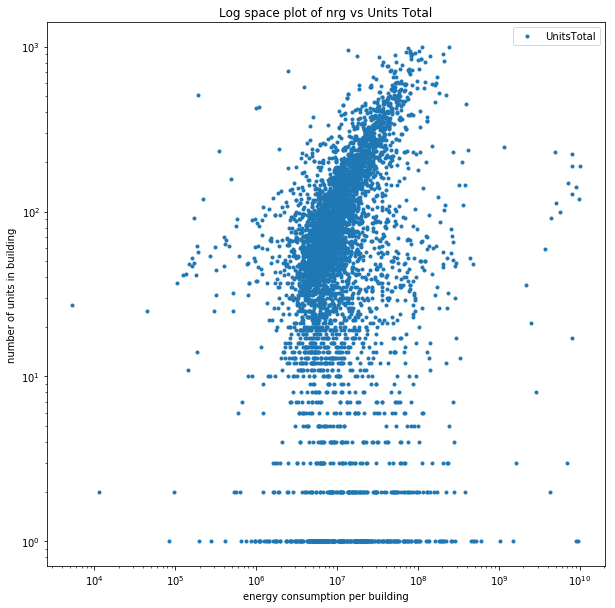

In [629]:
pl.figure(figsize=(10,10))
pl.title('Log space plot of nrg vs Units Total')
pl.loglog(bblnrgdataCut.nrg, bblnrgdataCut.UnitsTotal, '.')
pl.ylabel('number of units in building')
pl.xlabel('energy consumption per building')
pl.legend()

Figure 8 : Log space plot of nrg vs Units Total. Notice that there are some Units Total below 100 that seems to be rounded to a ten's digit. The units itself that has been generated by the graph is automatically stretched out for some units seemingly as well. 

# Fit the data with a line in log space:  

**make sure you print the summary and plot the data and the model**

## Model NRG as a linear function of number of units in the building 
Ciertainly there is a right way to think about this: which is the *independent* and the *dependent* variable? which do we think causes which? do units "cause"energy consumption or vice versa? please answer below

**answer**

However, indulge me and try both models: models (nrg vs units total & units total vs nrg). 

- create the models with statsmodels
- print the model summary
- plot the data and the fit
- Check and comment on how the following model diagnostics change: 
        R^2 and LogLikelihood
        
(remember to use only the data in the appropriate range, see the previous step)

### Units vs Energy

In [630]:
#I find the easiest way to use the formula package is to use a dataframe 
#with the quantities that are not linear already calculated

# you can do it whichever way is easy for you
bblnrgdataCut['logNrg']  = bblnrgdataCut.nrg.apply(lambda x: log(x))
bblnrgdataCut['logUnits'] = bblnrgdataCut.UnitsTotal.apply(lambda x: log(x+1))

OLS2 = smf.ols(formula='logNrg ~ logUnits',data=bblnrgdataCut).fit()
OLS2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 logNrg   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     123.5
Date:                Tue, 27 Nov 2018   Prob (F-statistic):           2.33e-28
Time:                        13:14:02   Log-Likelihood:                -7387.0
No. Observations:                4928   AIC:                         1.478e+04
Df Residuals:                    4926   BIC:                         1.479e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     15.7186      0.047    336.374      0.000        15.627    15.810
logUnits       0.1245      0.011     11.114      0.000         0.103     0.146
==============================================================================
Omnibus:                     1286.408   Durbin-Watson:                   1.874
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10437.718
Skew:                           1.018   Prob(JB):                         0.00
Kurtosis:                       9.833   Cond. No.                         13.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

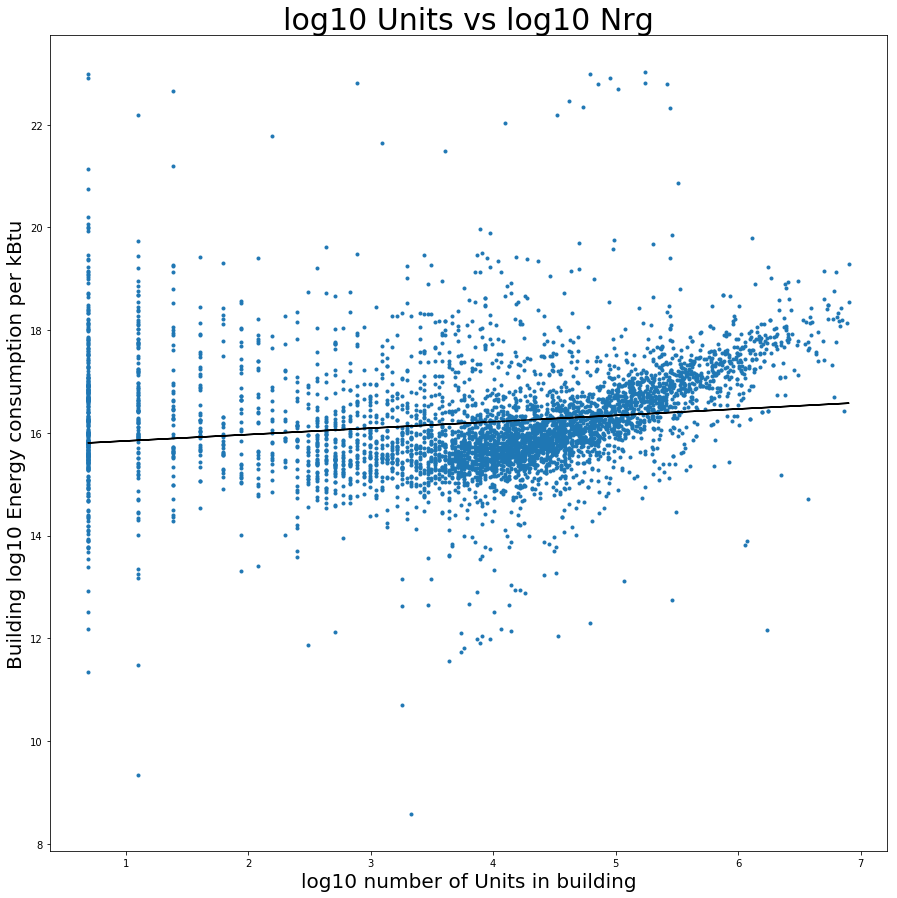

In [631]:
pl.figure(figsize=(15,15))
pl.plot(bblnrgdataCut.logUnits, bblnrgdataCut.logNrg, '.')
pl.plot(bblnrgdataCut.logUnits, OLS2.predict(bblnrgdataCut),'-', color='k')
pl.xlabel('log10 number of Units in building', fontsize=20)
pl.ylabel('Building log10 Energy consumption per kBtu', fontsize=20)
pl.title('log10 Units vs log10 Nrg', fontsize=30);

Figure 9 : Log space plot of Units Total vs Nrg with a linear fit line. Seemingly positive. However, the R-squared is extremely low, being 0.024, and so it is not a very good predictor of the results, and therefore there might be better ways to fit this than a linear line. The log-likelihood is -7387.0.

### Energy against Units

In [632]:
OLS2 = smf.ols(formula='logUnits ~ logNrg',data=bblnrgdataCut).fit()
OLS2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               logUnits   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     123.5
Date:                Tue, 27 Nov 2018   Prob (F-statistic):           2.33e-28
Time:                        13:14:07   Log-Likelihood:                -8510.1
No. Observations:                4928   AIC:                         1.702e+04
Df Residuals:                    4926   BIC:                         1.704e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.7525      0.287      2.621      0.009         0.190     1.315
logNrg         0.1964      0.018     11.114      0.000         0.162     0.231
==============================================================================
Omnibus:                      650.785   Durbin-Watson:                   1.878
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              932.635
Skew:                          -1.024   Prob(JB):                    3.03e-203
Kurtosis:                       3.589   Cond. No.                         242.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

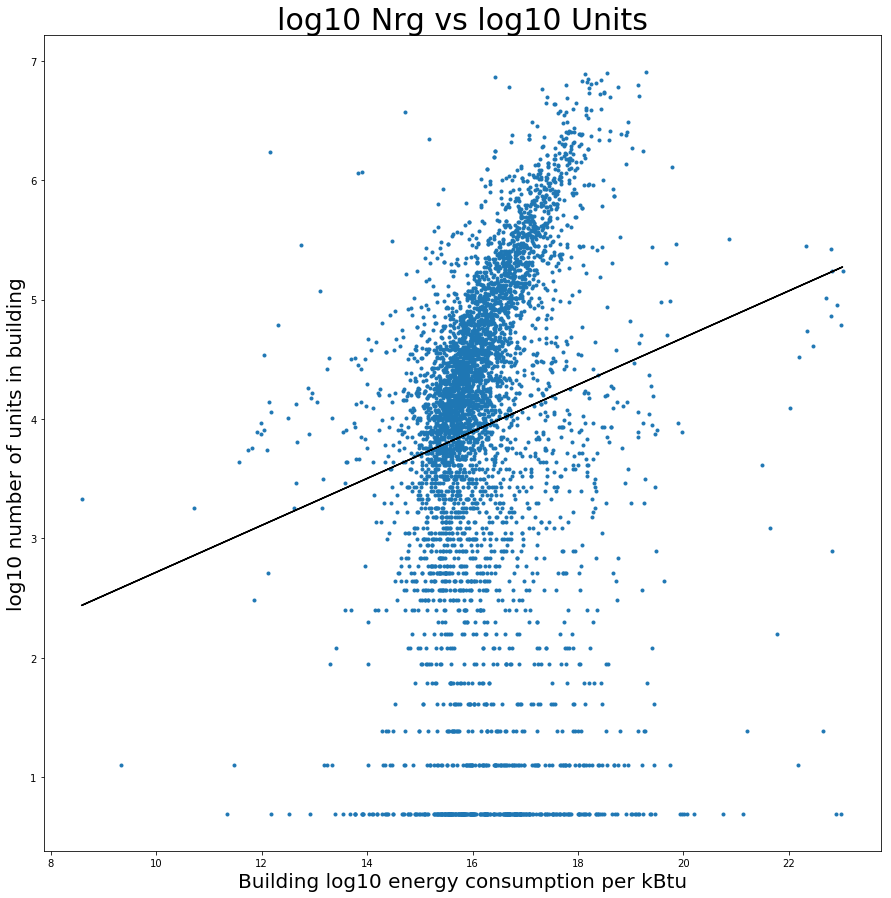

In [582]:
pl.figure(figsize=(15,15))
pl.plot(bblnrgdataCut.logNrg, bblnrgdataCut.logUnits, '.')
pl.plot(bblnrgdataCut.logNrg, OLS2.predict(bblnrgdataCut),'-', color='k')
pl.ylabel('log10 number of units in building', fontsize=20)
pl.xlabel('Building log10 energy consumption per kBtu', fontsize=20)
pl.title('log10 Nrg vs log10 Units', fontsize=30);

Figure 10 : Log space plot of Nrg vs Units Total with a linear fit line. Seemingly positive. However, the R-squared is extremely low, being 0.024, and so it is not a very good predictor of the results, and therefore there might be better ways to fit this than a linear line. The log-likelihood is -8510.1. Compared to -7387.0 of Units total vs Nrg, Units Total's linear fit is better.

# Second degree polynomial fit

model the data with a slightly more complex model: 
    
    y = ax*x + bx + c, 

instead of 
        
    y = bx + c
    
**make sure you print the summary and plot the data and the model**


### Units vs Energy (Polynomial)

In [633]:
#I find the easiest way to use the formula package is to use a dataframe 
#with the quantities that are not linear already calculated

# you can do it whichever way is easy for you

bblnrgdataCut['I(logUnits ** 2)'] = bblnrgdataCut['logUnits'] ** 2

OLS2 = smf.ols(formula='logNrg ~ I(logUnits ** 2) + logUnits',data=bblnrgdataCut).fit()
OLS2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 logNrg   R-squared:                       0.169
Model:                            OLS   Adj. R-squared:                  0.168
Method:                 Least Squares   F-statistic:                     499.7
Date:                Tue, 27 Nov 2018   Prob (F-statistic):          2.54e-198
Time:                        13:14:15   Log-Likelihood:                -6992.8
No. Observations:                4928   AIC:                         1.399e+04
Df Residuals:                    4925   BIC:                         1.401e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
Intercept           17.3013      0.069    249.912      0.000        17.166    17.437
I(logUnits ** 2)     0.1706      0.006     29.232      0.000         0.159     0.182
logUnits            -1.0312      0.041    -25.233      0.000        -1.111    -0.951
==============================================================================
Omnibus:                     1420.615   Durbin-Watson:                   1.905
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            18979.507
Skew:                           0.998   Prob(JB):                         0.00
Kurtosis:                      12.405   Cond. No.                         113.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

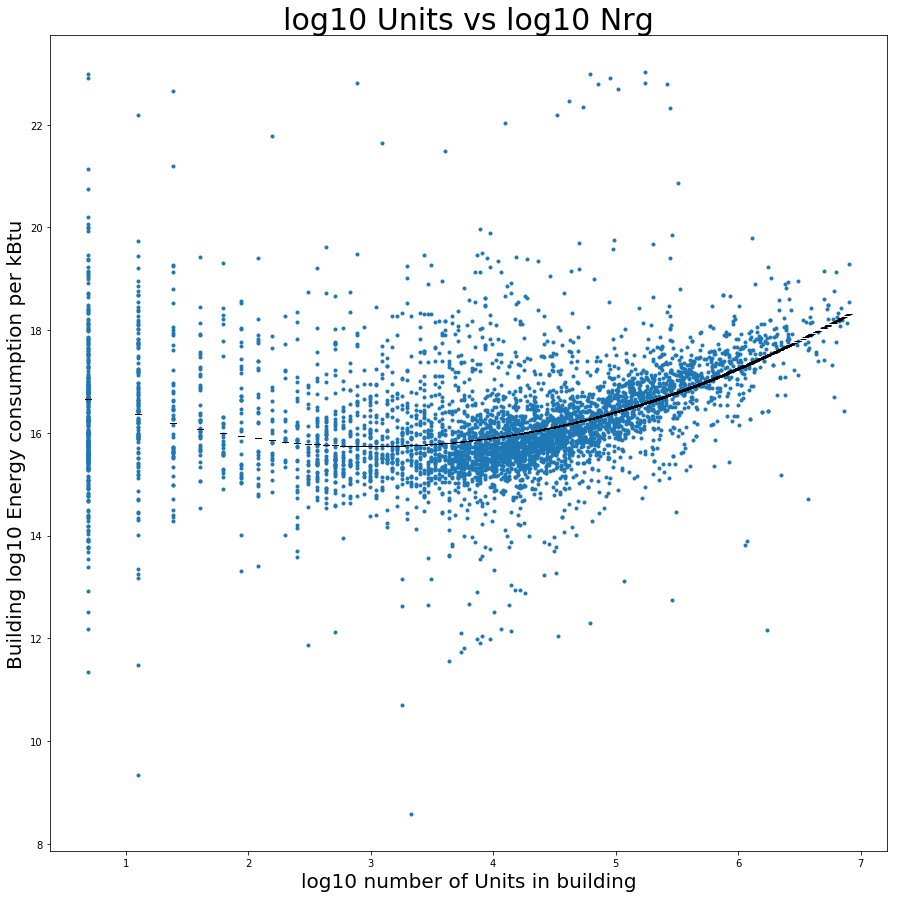

In [634]:
pl.figure(figsize=(15,15))
pl.plot(bblnrgdataCut.logUnits, bblnrgdataCut.logNrg, '.')
pl.plot(bblnrgdataCut.logUnits, OLS2.predict(bblnrgdataCut),'_', color='k')
pl.xlabel('log10 number of Units in building', fontsize=20)
pl.ylabel('Building log10 Energy consumption per kBtu', fontsize=20)
pl.title('log10 Units vs log10 Nrg', fontsize=30);

Figure 11 : Log space plot of Units Total vs Nrg with a polynomial fit line. Seemingly positive. The R-squared is better than the linear fit, being 0.169, and so it is a better predictor of the results. the log-likelihood is -6992.8.

### Energy against Units (polynomial)

In [635]:
bblnrgdataCut['I(logNrg ** 2)'] = bblnrgdataCut['logNrg'] ** 2

OLS2 = smf.ols(formula='logUnits ~ I(logNrg ** 2) + logNrg',data=bblnrgdataCut).fit()
OLS2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               logUnits   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     106.1
Date:                Tue, 27 Nov 2018   Prob (F-statistic):           7.91e-46
Time:                        13:14:23   Log-Likelihood:                -8467.2
No. Observations:                4928   AIC:                         1.694e+04
Df Residuals:                    4925   BIC:                         1.696e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
Intercept        -14.2579      1.639     -8.699      0.000       -17.471   -11.045
I(logNrg ** 2)    -0.0543      0.006     -9.299      0.000        -0.066    -0.043
logNrg             2.0062      0.195     10.267      0.000         1.623     2.389
==============================================================================
Omnibus:                      621.864   Durbin-Watson:                   1.885
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              878.431
Skew:                          -0.990   Prob(JB):                    1.78e-191
Kurtosis:                       3.595   Cond. No.                     2.29e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.29e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

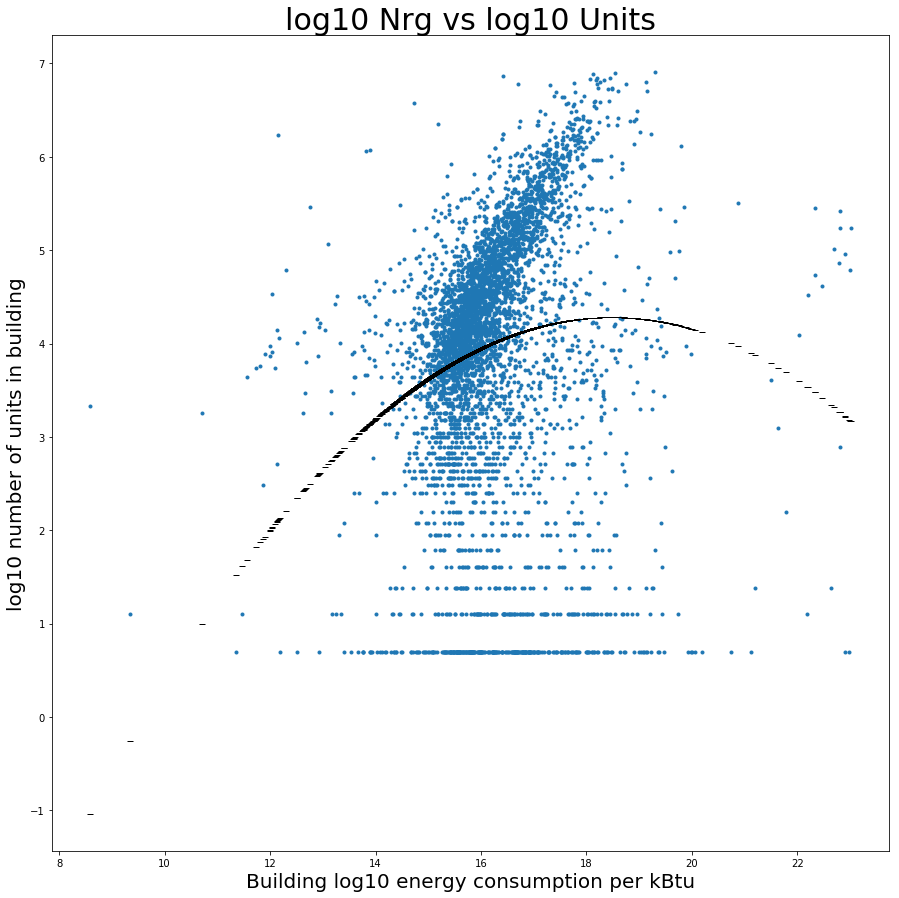

In [586]:
pl.figure(figsize=(15,15))
pl.plot(bblnrgdataCut.logNrg, bblnrgdataCut.logUnits, '.')
pl.plot(bblnrgdataCut.logNrg, OLS2.predict(bblnrgdataCut),'_', color='k')
pl.ylabel('log10 number of units in building', fontsize=20)
pl.xlabel('Building log10 energy consumption per kBtu', fontsize=20)
pl.title('log10 Nrg vs log10 Units', fontsize=30);

Figure 12 : Log space plot of Nrg vs Units Total with a polynomial fit line. Seemingly positive. The R-squared is better than the linear fit, being 0.041, and so it is a better predictor of the results, but it is not better than the fit for Units Total vs Nrg. The log-likelihood of this is -8467.2. COmpared to Units Total vs Nrg of -6992.8, Units total vs Nrg is a better fit model.

# calculate the chi square and likelihood of your model

## Define a chisquare function

In [636]:
#leave
def chi2(data, model, errors = 1):
    '''Calculates the chi sq given data, model and errors
    Arguments:
    data: series of datapoints (endogenous variable)
    model: series of predicted values corresponding to the observed data
    errors: serie of errors (optional). 
    If errors are not passes all errors are set to 1
    
    chisq = ( sum of (observed - Expected value)^2 / errors ^ 2 / DOF)
    
    DOF is given with the errors?
    
    '''
    #chisq = sp.stats.chisquare(data, model, ddof=0, axis=0)[0]
    chisq = np.sum((data - model)**2 / errors**2)
    return chisq
    

## Define and calculate errors

Assume Poisson statistics and calculate the errors accordingly. Remember that you have used 2 quantities combined linearly to calculate the energy (your *dependent* variable) , so the errors combine in quadrature!

    Total Error = sqrt(error1^2 + error2^2)
    
Your *independent* variable has uncertainty also! assume it is also Poissonian

** propagation of errors on the log:**
https://en.wikipedia.org/wiki/Propagation_of_uncertainty#Linear_combinations

$f=a\log _{10}(A)$

$\sigma _{f}\approx \left(a{\frac {\sigma _{A}}{A\ln(10)}}\right)$

In [637]:
## Assume that there is error in the reported energy. 
## but that is the product of two measured qusntities, each of which will have errors. 
## The minimum error is the squareroot of the value

#error(x1) = sqrt(x1)
#error(x2) = sqrt(x2)
#error(x1 / x2)  = sqrt(error(x1)**2 _ error(x2)**2 )

#and finally

#error( log(x1  /x2)) = (error( x1/x2) / (x1/x2) / np.log(10) ) 

#errors on the measured quantities

bblnrgdataCut.errorsnrg = (np.sqrt(bblnrgdataCut['Reported Property Floor Area (Building(s)) (ft²)']**2 +
                bblnrgdataCut['Site EUI(kBtu/ft2)']**2)) / bblnrgdataCut.nrg / np.log(10)

# better WOULD BE to calculate each error and add in quadrature: sqrt(1/A + 1/B) which becomes
#errorsnrg = np.sqrt(1.0 / bblnrgdataCut['Reported Property Floor Area'] + 1.0 / bblnrgdataCut['Site EUI(kBtu/ft2)'])
#but this leads to insane error values (insanely small)

## Assume count statistics in the number of units as well
bblnrgdataCut.errorsunits = np.sqrt(bblnrgdataCut['UnitsTotal']) / (bblnrgdataCut['UnitsTotal']) / np.log(10)


## Make 3 plots: one with x errors, one with y errors, one with x and y errors. 

with pylab you can do it with pl.errorbar(x, y, xerr=xerror, yerr=yerror)

The largest error bar is for


,UnitsRes,UnitsTotal,YearBuilt,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),nrg,logNrg,logUnits,I(logUnits ** 2),I(logNrg ** 2)
3313,27,27,1909,1.019900e+09,0.1,53440.0,5344.0,8.58373,3.332205,11.103587,73.680416


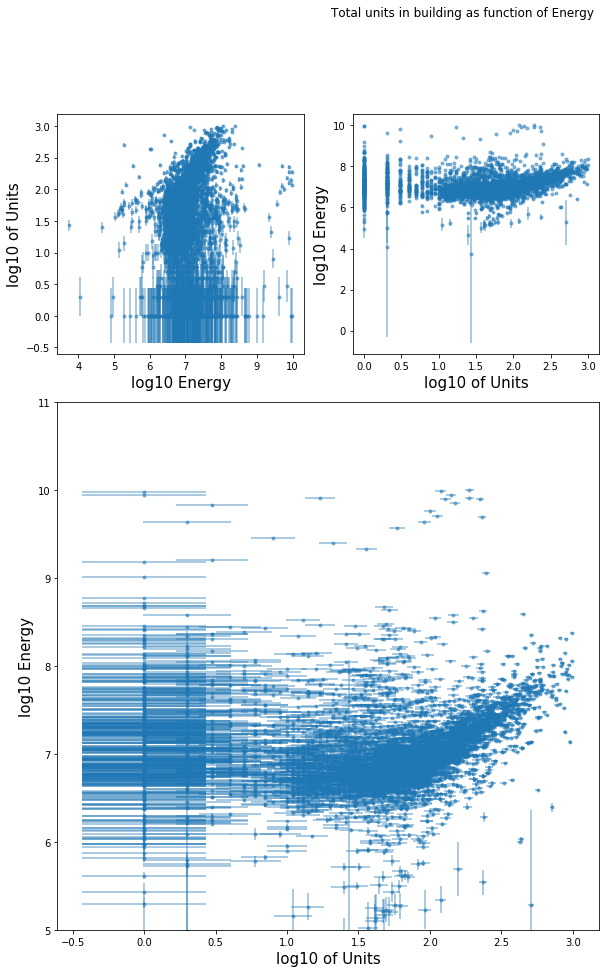

In [638]:
#I could also include errors for number of units
#fig2 = plt.figure(constrained_layout=True, figsize=(15,15))
fig2 = plt.figure(figsize=(15,15))

#gs1 = gridspec.GridSpec(3, 3, figure=fig2)
gs1 = gridspec.GridSpec(3, 3, fig2)

gs1.update(left=0.68, right=0.68, wspace=0.2)


ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=1)
ax1.errorbar(np.log10(bblnrgdataCut.nrg), np.log10(bblnrgdataCut.UnitsTotal), 
            yerr=bblnrgdataCut.errorsunits, fmt='.',
            alpha=0.5)
ax1.set_ylabel("log10 of Units", fontsize=15)
ax1.set_xlabel("log10 Energy", fontsize=15)
pl.suptitle("Total units in building as function of Energy")


ax2 = plt.subplot2grid((3, 3), (0, 1), colspan=1)
ax2.errorbar(np.log10(bblnrgdataCut.UnitsTotal), np.log10(bblnrgdataCut.nrg), 
            yerr=bblnrgdataCut.errorsnrg, fmt='.',
            alpha=0.5)
ax2.set_xlabel("log10 of Units", fontsize=15)
ax2.set_ylabel("log10 Energy", fontsize=15)

ax4 = plt.subplot2grid((3, 3), (1, 0), colspan=2, rowspan=2)
ax4.errorbar(np.log10(bblnrgdataCut.UnitsTotal), np.log10(bblnrgdataCut.nrg), 
            yerr=bblnrgdataCut.errorsnrg,
           xerr=bblnrgdataCut.errorsunits, alpha=0.5, fmt='.')
ax4.set_xlabel("log10 of Units", fontsize=15)
ax4.set_ylabel("log10 Energy", fontsize=15)
ax4.set_ylim(5,11)

print ("The largest error bar is for")
bblnrgdataCut[bblnrgdataCut.errorsnrg == bblnrgdataCut.errorsnrg.max()]

Figure 15: The same as Figure 13 and 14, but with errorbars. In the top panel the errors on the Units in the building are plotted, in the bottom panels the errors on the energy are plotted, but they are too small to see,  and both on the right side panel. The bottom right panel is a zoom-in of the bottom left panel. Errors are measured by assuming Poisson statistics at the measurement level for energy per square foot, squarefootage, and for the number of units, and propagate properly to the log space. Notice that we do not know what the units of energy really represent: the Poisson statitics should be applied to the measured counts, but the enrgy consumption is a continuous variable, only discretized by the act of measuring it. 

IMPORTANT! errors as the square root of the measurement (Poisson statistics) are ONLY meaningful when you are potting dimensionless quantoities! here it is preposterous to assume that the errors are the square root of the measurement. WHY? because then if I express my energy by sq meter, instead of sq feet, I get a different error on the measurement for the same measurement - which makes no sense! However, in this case, I am not using the errors to create the model (no WLS for example) so this error allows me to compare uncertainty on the datapoints. Even if the errors are different, under linear transformations (changes of units for example) the relationship between errors on 2 datapoints will be preserved. 

Notice: No points are taken off if other errors are used, including the sqrt of the log energy, and the correct errors propagation in the log on errors calculated, however, as the sqrt of the tot energy per building, but the errors are in the measured quantities, so this is the proper way to obtain them. In addition the units of energy are extremely large, thus the errors in percentage on the energy are extremely small. These errors are likely to be underestmated due to our ignorance of the details of the experiment.

## Add the errors and calculate the chi square


### calculate the degrees of freedom of this model

In [639]:
linmodel_0 = smf.ols(formula='logNrg ~ logUnits',data=bblnrgdataCut).fit()
linmodel_0.params.shape

(2,)

In [640]:
linmodel_1 = smf.ols(formula='logUnits ~ logNrg',data=bblnrgdataCut).fit()
linmodel_1.params.shape

(2,)

In [641]:
bblnrgdataCut.shape

(4928, 11)

In [642]:
#degrees of freedom: number of observations - number of model parameters
# note: these are reported as dof of the residuals in the statsmodels fit summary, but jsut to make sure let's calculate them
dof = bblnrgdataCut.shape[0] - linmodel_0.params.shape[0]
print ("degrees of freedom:" , dof)

degrees of freedom: 4926


In [650]:
print ("Units vs Energy residuals (no errors include): %.2f"%\
       (chi2(np.log10(bblnrgdataCut.UnitsTotal), linmodel_0.predict()) / 
        float(dof)))

print ("Units vs Energy chi square per DOF w independent variable error only: %.2f"%\
       (chi2(np.log10(bblnrgdataCut.UnitsTotal), linmodel_0.predict(), 
            errors = bblnrgdataCut.errorsnrg) / dof))

print ("Units vs Energy chi square per DOF : %.2f"%\
       (chi2(np.log10(bblnrgdataCut.UnitsTotal), linmodel_0.predict(), 
            errors = np.sqrt(bblnrgdataCut.errorsnrg**2 + 
                             bblnrgdataCut.errorsunits**2))  / dof))


Units vs Energy residuals (no errors include): 211.53
Units vs Energy chi square per DOF w independent variable error only: 8678771806.40
Units vs Energy chi square per DOF : 101736.72


In [651]:
print ("Energy vs Units residuals (no errors include): %.2f"%\
       (chi2(np.log10(bblnrgdataCut.nrg), linmodel_1.predict()) / dof))

print ("Energy vs Units chi square per DOF w independent variable error only: %.2f"%\
       (chi2(np.log10(bblnrgdataCut.nrg), linmodel_1.predict(), 
            errors = bblnrgdataCut.errorsnrg) / dof))

print ("Energy vs Units chi square per DOF : %.2f"%\
       (chi2(np.log10(bblnrgdataCut.nrg), linmodel_1.predict(), 
            errors = np.sqrt(bblnrgdataCut.errorsnrg**2 + 
                             bblnrgdataCut.errorsunits**2))  / dof))


Energy vs Units residuals (no errors include): 9.70
Energy vs Units chi square per DOF w independent variable error only: 856355021.99
Energy vs Units chi square per DOF : 5316.98


### Compare the models using the  chi square:

Without errors, Units vs Energy residuals are 211.53 and Energy vs Units residuals are 9.70. 9.70 is therefore closer to 1, and therefore will have a lower chance of overfitting, and therefore Energy vs Units residuals are better in terms of the chi-square than Units vs Energy residuals. These models have the same R-squared and shape, so checking using the chi-squared may be better in this case. 

If the result of the units vs energy surprises you plot the influence plot for the model. Except the default statsmodels influence plot is a bit of a mess, cause so many points have high leverage, and thus high influence, that the labels cover the span of the plot and make it useless. One could relatively easily engineered one's own influence plot, but instead for the purpose of this discussion comparing the units vs energy with the energy vs units influence plot is sufficient to show how many more points with high **leverage** are in the first plot than in the second - look at the axis range! What is happening is that the distribution of points along the exogenous variable is much better suited to a line fit in the energy vs units plot. You want a large spread in the exogenous variable. In the units vs energy most values of the exogenous variable (energy in this case) are clustered in a small range, while the endogenous variable varies greatly for those points. So the core of the distribution has low predictive power, and the importance of the "outliers" with high and low energy values is enhanced in the fit. 

Figure 10: ...

# Comparing the linear and curve fit with Likelihood Ratio LR test; we require a significance $\alpha=0.05$

** The curve fit and linear fit od the Energy vs Units can be compared with LR test because they are nested models**

** The difference in the number of degrees of freedom is 1, so the LR statistics will follow a $\chi^2$ distribution with 1 DOF.**


In [645]:
linmodel_2 = smf.ols(formula='logNrg ~ I(logUnits ** 2) + logUnits',data=bblnrgdataCut).fit()

linmodel_2.compare_lr_test(linmodel_0)

(788.46715819504243, 1.7359259734559824e-173, 1.0)

LR = 788.46715

p-value < 0.05

With a DOF of 1, and a statistic of 788.46715, the p-value is far less than 0.05 or even 0.01,

so we should reject the null hypothesis in favor of the alternative hypothesis that the curve fit is better.

## EC 1 Plotting the likelihood surface (assuming gaussian statistics)

when you assume Gaussian statistics the log likelihood is the chi square, so you can plot the chi square from the function you created earlier!

* choose a reasonable range of a, b, and c for your parameters. 
* calculate the chisquare for each value in the range: this can be done in a nested for loop
* save the value of the chi square and plot it as a surface

in pylab you can plot surfaces with pl.imshow()


### creating a function that returns the likelihood value on a grid
We already have the function! If we assume a Gaussian distribution then the likelihood is the chi square (not exactly, but it is a linear function of the chi squared, which means that maximizing the log likelihood is the same as minimizing the chi square).
this is a brute force minimization, which is escruciatingly slow and should not be done due to its inefficiency, but it is a transparent code that allows you to see what it means to maximize the likelihood surface (which is equivalent to minimizing the sum of the residuals squared, or the chi squared if errors are used)

### calculating and plotting the loglikelihood in a 2D sensible range of values
plot is for 
    - chi square calculated with no errors (i.e. sum of residuals squared)
    - chi squared with errors
    
compare the surfaces

//anaconda/envs/GEOP/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
//anaconda/envs/GEOP/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


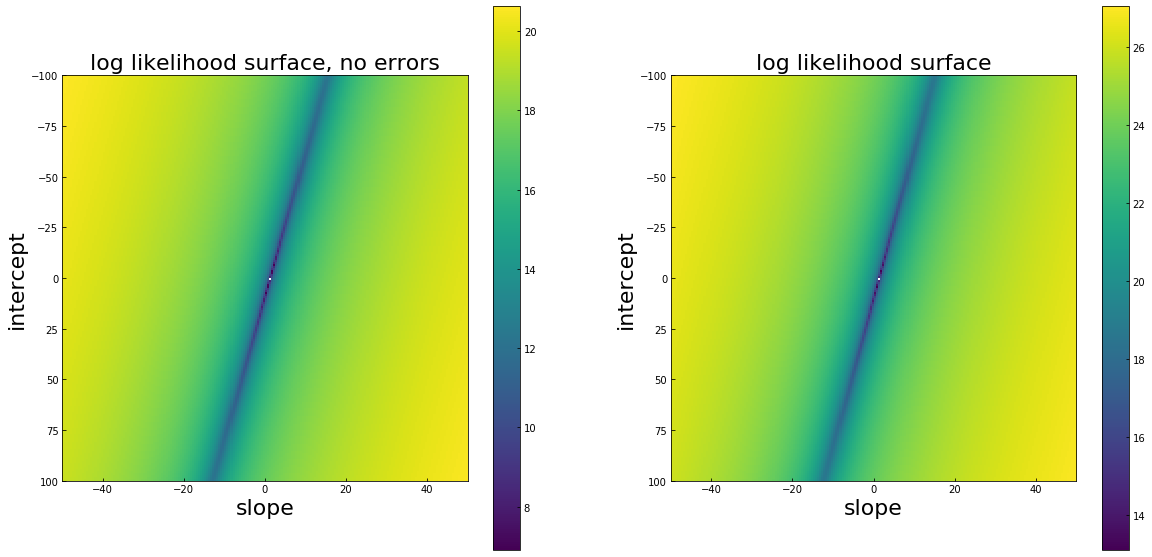

In [124]:
fig = pl.figure(figsize=(20,10))
ax1 = fig.add_subplot(121)
ax1.set_title ("log likelihood surface, no errors", fontsize = 22)
pl.imshow(np.log(resids_noerror), extent = [-50,50,100,-100], aspect=0.5)
ax1.set_xlabel('slope', fontsize = 22)
ax1.set_ylabel('intercept', fontsize = 22)
pl.colorbar()

ax2 = fig.add_subplot(122)
ax2.set_title ("log likelihood surface", fontsize = 22)
pl.imshow(np.log(resids), extent = [-50,50,100,-100], aspect=0.5)
ax2.set_xlabel('slope', fontsize = 22)
ax2.set_ylabel('intercept', fontsize = 22)
pl.colorbar();


Figure 11: ...

//anaconda/envs/GEOP/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
//anaconda/envs/GEOP/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in subtract
  after removing the cwd from sys.path.


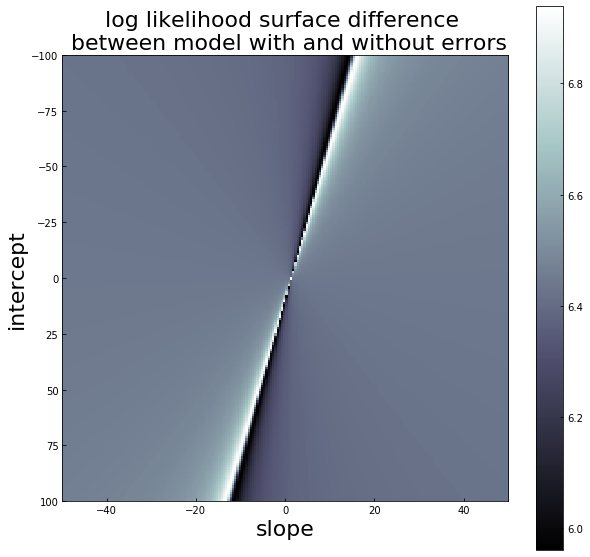

In [125]:
#leave
#plotting the difference between the 2 likelihood surfaces to see if the minimum is in the right place
ax1 = pl.figure(figsize=(10,10)).add_subplot(111)
ax1.set_title ("log likelihood surface difference \n between model with and without errors", fontsize = 22)
pl.imshow(np.abs(np.log(resids) - np.log(resids_noerror)), extent = [-50,50,100,-100], aspect=0.5, cmap='bone')
ax1.set_xlabel('slope', fontsize = 22)
ax1.set_ylabel('intercept', fontsize = 22)
pl.colorbar();


Figure 12: ...

# EXTRA CREDIT: a plot of anything related to these data

//anaconda/envs/GEOP/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
//anaconda/envs/GEOP/lib/python3.6/site-packages/pandas/core/generic.py:5984: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
//anaconda/envs/GEOP/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2910: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


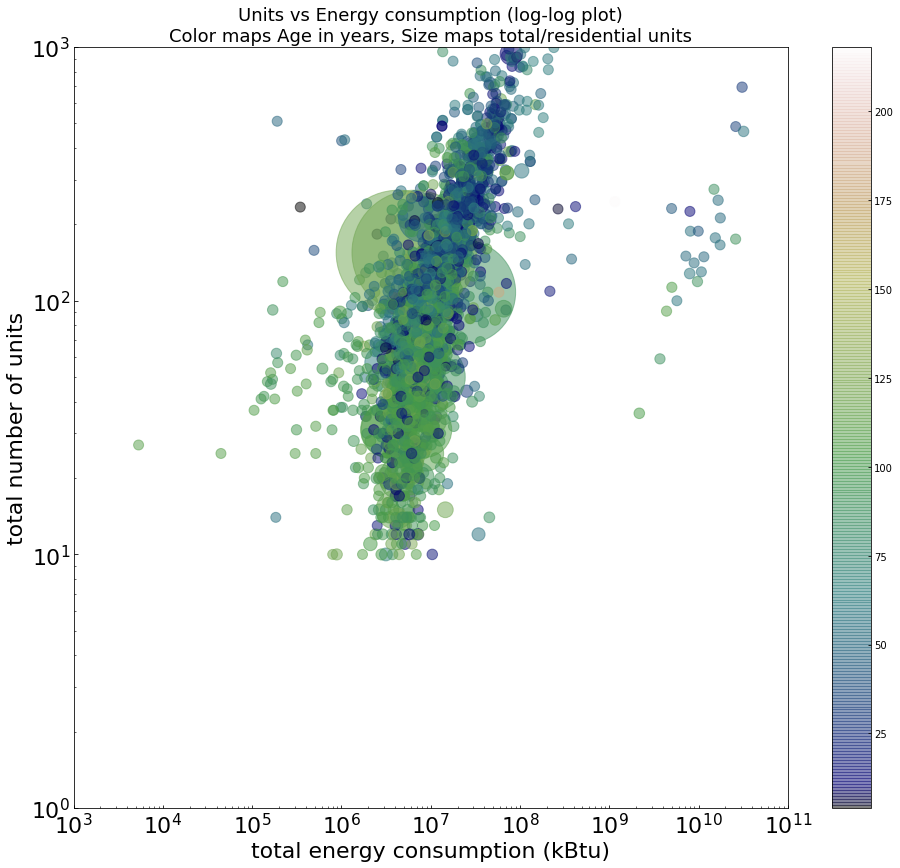

In [126]:
ax = pl.figure(figsize=(10,10)).add_subplot(111)
bblnrgdataCut['YearBuilt'][bblnrgdataCut['YearBuilt']<1800]=1800

bblnrgdataCut.plot(kind='scatter', x='nrg', y='UnitsTotal', 
                fontsize=22, colormap='gist_earth', alpha = 0.5, 
                marker='o',  figsize=(16, 14), loglog=True,  
                xlim=(1000,1e11), ylim=(1,1000), ax = ax,
                c= dt.datetime.today().year - bblnrgdataCut['YearBuilt'], 
                s=bblnrgdataCut['UnitsTotal']/bblnrgdataCut['UnitsRes'] * 100)
pl.title('Units vs Energy consumption (log-log plot)\nColor maps Age in years, Size maps total/residential units', 
         fontsize=18)
pl.ylabel("total number of units", fontsize=22)
pl.xlabel("total energy consumption (kBtu)", fontsize=22);


Figure 13: Plot of Number of Units as a function of energy consumption for all NYC buildings with self reported energy consumption in the Local Law 84 database. The color of each datapoint representes the age: darker colors are buildings of more recent construction. The size of the mark represents the inverse of the fraction of residential units in the building (large datapoints indicate a small fraction of residential units, i.e. a comercial building). 

There is a weak color gradient where younger buildings dominate the higher portion of the plot. This could be interpreted as higher efficiency: at the same energy consumption younger buildings host more people. Or it could be driven by architectural changes: a trend to host the same number of people segregating them in more smaller units.

Aside from a few obvious outliers there is no obvious trend in fraction of residential units with building age, energy, or total number of units